Calibration attempt

In [ ]:
#Get temperature data from MC134
from __future__ import print_function
from time import sleep
from sys import stdout
from daqhats import mcc134, HatIDs, HatError, TcTypes
from daqhats_utils import select_hat_device, tc_type_to_string


import numpy as np
import matplotlib.pyplot as plt



tc_type = TcTypes.TYPE_K   # change this to the desired thermocouple type
delay_between_reads = 1  # #To specify, Seconds 
N_measures = 5 #To specify
channels = (0, 1) #To specify
T_array = np.zeros((N_measures,len(channels))) # List of temperatures for both sensors in Celsius



try:
    # Get an instance of the selected hat device object.
    address = select_hat_device(HatIDs.MCC_134)
    hat = mcc134(address)

    for channel in channels:
        hat.tc_type_write(channel, tc_type)
    
    for i in range(N_measures):
        # Read a single value from each selected channel.
        for channel in channels:
            value = hat.t_in_read(channel)
            T_array[i,channel] = value
            #print(value, '', i)
            
        # Wait the specified interval between reads.
        sleep(delay_between_reads)
        
    #print(T_array)


except (HatError, ValueError) as error:
    print('\n', error)



In [ ]:
T_array

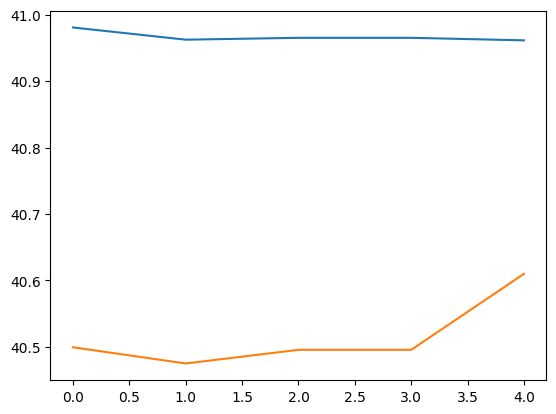

In [12]:
import matplotlib.pyplot as plt
plt.plot(T_array)
plt.show()

Trigger input test

In [ ]:
import RPi.GPIO as GPIO

# Set the GPIO mode to BCM
GPIO.setmode(GPIO.BCM)

# Define the GPIO pin number
trigger_pin = 17

# Set up the GPIO pin as an input with an initial high state
GPIO.setup(trigger_pin, GPIO.IN, pull_up_down=GPIO.PUD_UP)

# Define the function to run when the trigger input is detected
def trigger_callback(channel):
    print("Trigger input detected!")

# Add the event detection for the falling edge of the trigger input
GPIO.add_event_detect(trigger_pin, GPIO.FALLING, callback=trigger_callback)

try:
    print("Waiting for trigger input...")
    while True:
        pass

except KeyboardInterrupt:
    print("Exiting...")
    GPIO.cleanup()



Waiting for trigger input...
